# Heart failure clinical records

## 1 Opis problemu

### 1.1 Zbiór danych

Zbiór danych Heart Failure Clinical Records zawiera 299 rekordów opisujących pacjentów, którzy doświadczyli niewydolności serca. Każdy rekord zawiera 13 cech klinicznych, które charakteryzują stan zdrowia pacjenta oraz przebieg leczenia. Dane te, zebrane w trakcie okresu obserwacji pacjentów, stanowią cenne źródło informacji klinicznych, umożliwiające głęboką analizę biostatystyczną oraz budowę modeli prognostycznych.

Opis cech:

- age: Wiek pacjenta w latach.
- anaemia: Czy pacjent cierpi na anemię (0 – nie, 1 – tak).
- creatinine_phosphokinase (CPK): Poziom enzymu CPK we krwi (mcg/L).
- diabetes: Czy pacjent ma cukrzycę (0 – nie, 1 – tak).
- ejection_fraction: Procentowa ilość krwi opuszczająca serce przy każdym skurczu (%).
- high_blood_pressure: Czy pacjent ma nadciśnienie (0 – nie, 1 – tak).
- platelets: Liczba płytek krwi w mikrolitrze krwi (kilopłytki/mL).
- serum_creatinine: Poziom kreatyniny w surowicy krwi (mg/dL).
- serum_sodium: Poziom sodu w surowicy krwi (mEq/L).
- sex: Płeć pacjenta (0 – kobieta, 1 – mężczyzna).
- smoking: Czy pacjent palił papierosy (0 – nie, 1 – tak).
- time: Czas obserwacji pacjenta w dniach.
- death_event: Zmienna docelowa (0 – pacjent przeżył, 1 – pacjent zmarł).

Źródło i szczegóły:

Dane zostały udostępnione przez Davide Chicco i Giuseppe Jurman w artykule „Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone” opublikowanym w BMC Medical Informatics and Decision Making w 2020 roku.

https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

### 1.2 Załadowanie wszystkich potrezbnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### 1.3 Załadowanie zbioru danych


In [2]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## 2 Opis danych

### 2.1 Statystyki opisowe

Zbiór danych Heart Failure Clinical Records składa się z 299 obserwacji i 13 cech, które opisują stan zdrowia pacjentów z niewydolnością serca. Wszystkie kolumny są kompletne – nie występują żadne brakujące wartości.

In [ ]:
print(data.info())


Podstawowe informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory 

Dla każdej wybranej kolumny danych numerycznych sprawdzone zostały podstawowe statystyki, takie jak: liczba obserwacji, średnia, odchylenie standardowe, wartości minimalne i maksymalne oraz kwartyle (25%, 50% i 75%).

In [4]:
print("\nStatystyki opisowe dla pełnej próbki - dane numeryczne:")
kolumny_do_statystyki = ['age', 'creatinine_phosphokinase','ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
print(data[kolumny_do_statystyki].describe())


Statystyki opisowe dla pełnej próbki - dane numeryczne:
              age  creatinine_phosphokinase  ejection_fraction      platelets  \
count  299.000000                299.000000         299.000000     299.000000   
mean    60.833893                581.839465          38.083612  263358.029264   
std     11.894809                970.287881          11.834841   97804.236869   
min     40.000000                 23.000000          14.000000   25100.000000   
25%     51.000000                116.500000          30.000000  212500.000000   
50%     60.000000                250.000000          38.000000  262000.000000   
75%     70.000000                582.000000          45.000000  303500.000000   
max     95.000000               7861.000000          80.000000  850000.000000   

       serum_creatinine  serum_sodium        time  
count         299.00000    299.000000  299.000000  
mean            1.39388    136.625418  130.260870  
std             1.03451      4.412477   77.614208  
min  

Przeanalizowano dane kategoryczne, aby sprawdzić rozkład poszczególnych cech w całej próbie oraz w podgrupach pacjentów zmarłych i ocalałych. Dla każdej kategorii obliczono liczebność oraz procentowy udział w pełnej próbie, a także oddzielnie dla pacjentów, którzy zmarli i tych, którzy przeżyli.

In [5]:
def describe_categorical_feature(df, feature):
    total_count = df[feature].value_counts().sort_index()
    total_percent = round(100 * total_count / len(df), 2)
    
    dead = df[df['DEATH_EVENT'] == 1]
    dead_count = dead[feature].value_counts().sort_index()
    dead_percent = round(100 * dead_count / len(dead), 2)
    
    survived = df[df['DEATH_EVENT'] == 0]
    survived_count = survived[feature].value_counts().sort_index()
    survived_percent = round(100 * survived_count / len(survived), 2)
    
    result = pd.DataFrame({
        'Full sample #': total_count,
        'Full sample %': total_percent,
        'Dead patients #': dead_count,
        'Dead patients %': dead_percent,
        'Survived patients #': survived_count,
        'Survived patients %': survived_percent
    })
    result.index = [f"{feature} (0: false)", f"{feature} (1: true)"]
    return result

categorical_features = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking']
print("\nStatystyki opisowe dane kategoryczne:")
tables = []
for feature in categorical_features:
    table = describe_categorical_feature(data, feature)
    tables.append(table)

final_table = pd.concat(tables)
final_table.reset_index(inplace=True)
final_table.columns = ['Category feature', 'Full sample  #', 'Full sample %', 'Dead patients #', 'Dead patients %', 'Survived patients #', 'Survived patients %']
final_table


Statystyki opisowe dane kategoryczne:


,Category feature,Full sample #,Full sample %,Dead patients #,Dead patients %,Survived patients #,Survived patients %
0,anaemia (0: false),170,56.86,50,52.08,120,59.11
1,anaemia (1: true),129,43.14,46,47.92,83,40.89
2,high_blood_pressure (0: false),194,64.88,57,59.38,137,67.49
3,high_blood_pressure (1: true),105,35.12,39,40.62,66,32.51
4,diabetes (0: false),174,58.19,56,58.33,118,58.13
5,diabetes (1: true),125,41.81,40,41.67,85,41.87
6,sex (0: false),105,35.12,34,35.42,71,34.98
7,sex (1: true),194,64.88,62,64.58,132,65.02
8,smoking (0: false),203,67.89,66,68.75,137,67.49
9,smoking (1: true),96,32.11,30,31.25,66,32.51


In [6]:
print("\nSprawdzenie braków danych:")
print(data.isnull().sum())


Sprawdzenie braków danych:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### 2.2 Wizualizacje danych

Wizualizacja danych za pomocą histogramów pozwala na analizę rozkładu poszczególnych cech w zbiorze danych. Na wykresach można zaobserwować, jak wartości danych numerycznych są rozłożone. Dzięki temu można lepiej zrozumieć strukturę danych oraz zidentyfikować cechy, które mogą mieć większy wpływ na wynik modelu.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

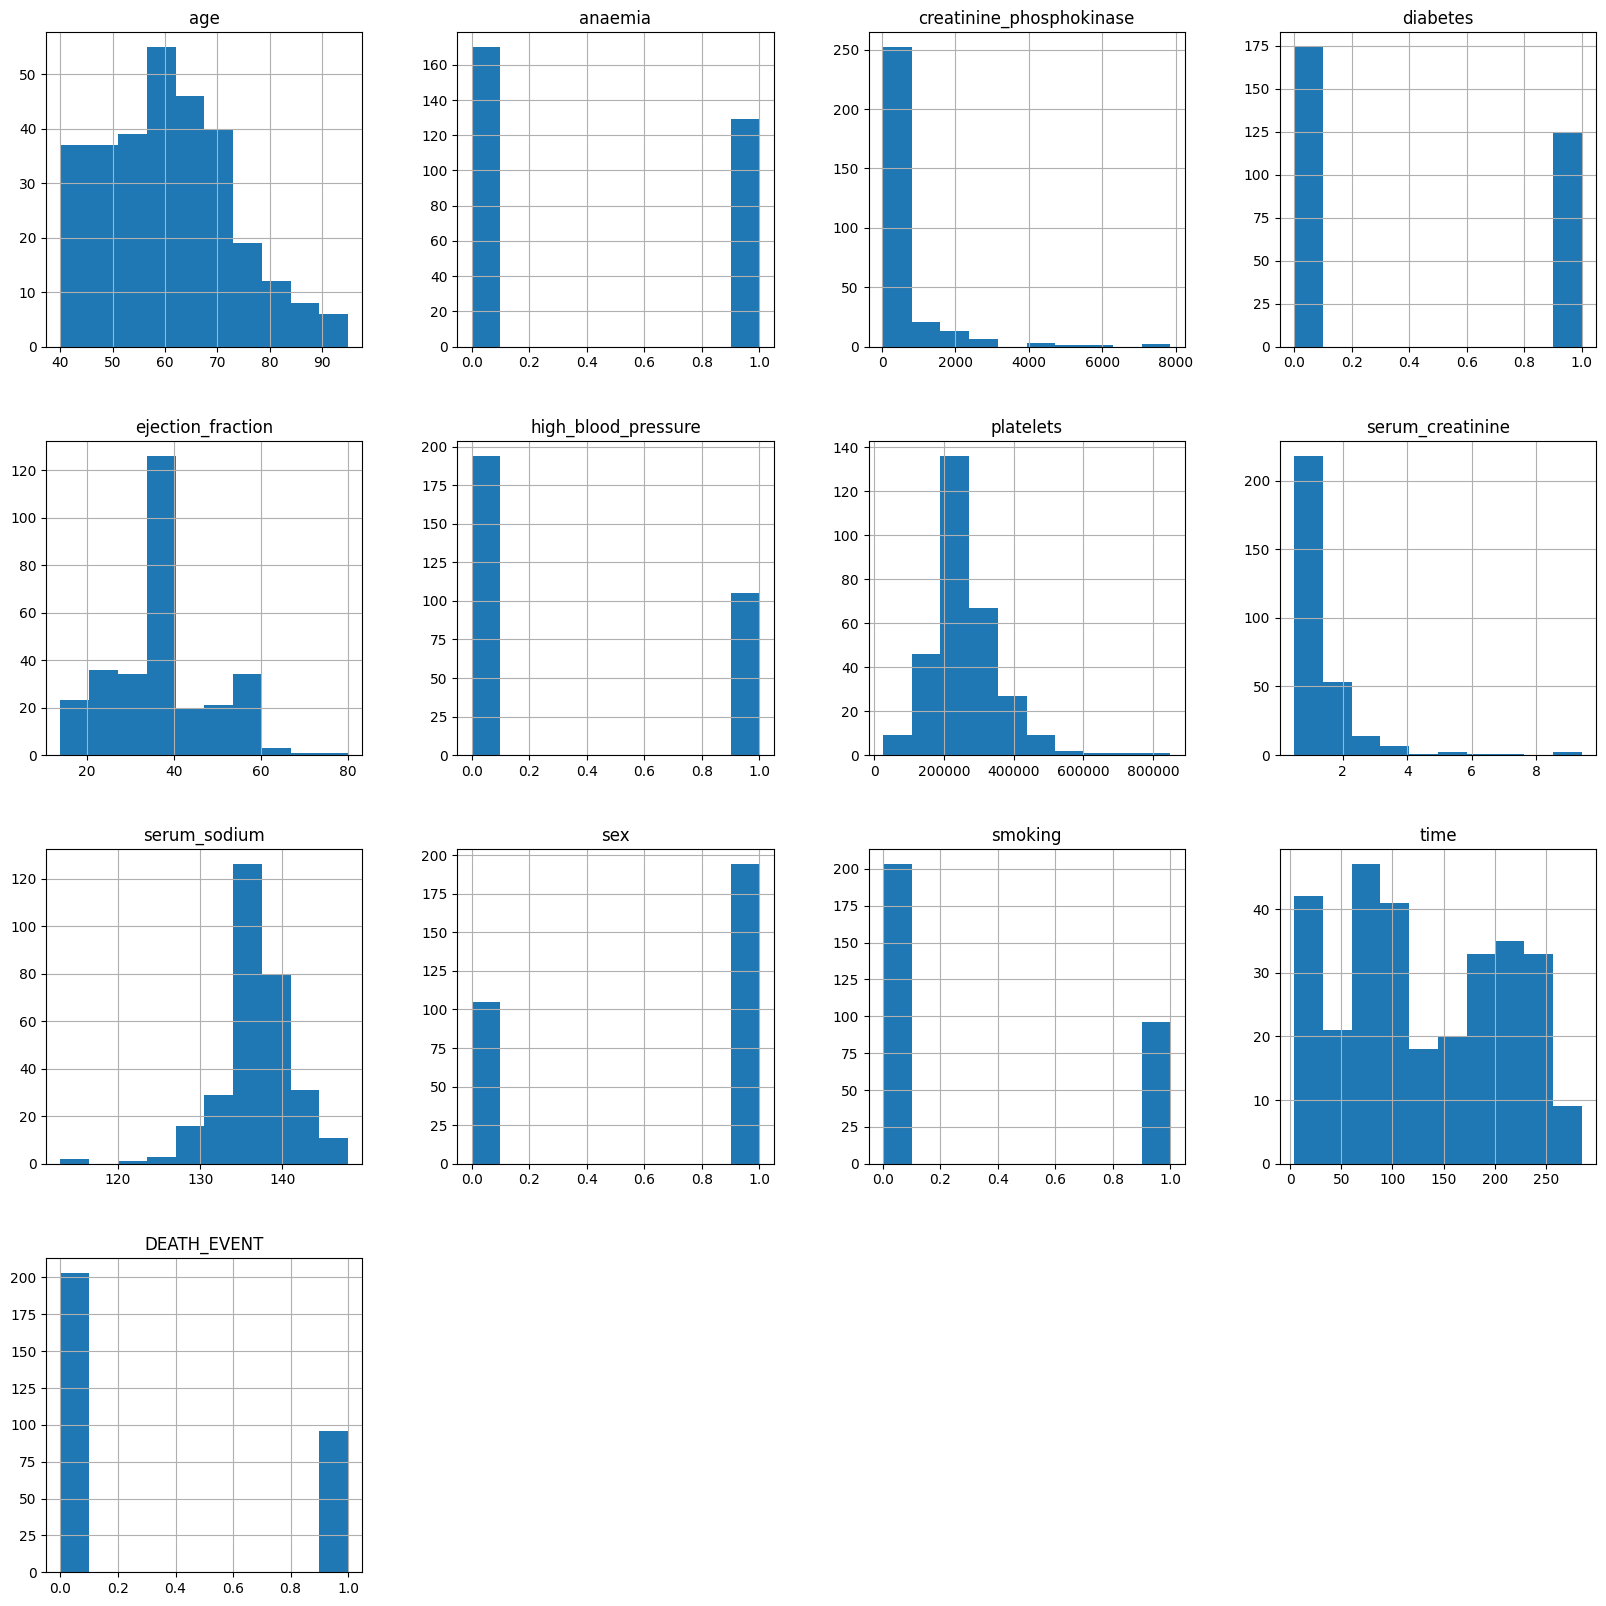

In [7]:
data.hist(bins=10, figsize=(20,20))

Z analizy macierzy korelacji wynika, że największa korelacja odwrotna wynosi -0.53 i występuje między cechami time a DEATH_EVENT. Największa korelacja dodatnia jest między smoking a sex i wynosi 0.45, chociaż nie jest to istotne dla celu tego badania. Natomiast korelacja na poziomie 0.29 między DEATH_EVENT a serum_creatinine sugeruje, że ta cecha może mieć znaczący wpływ na modele predykcyjne i warto ją uwzględnić w dalszej analizie.

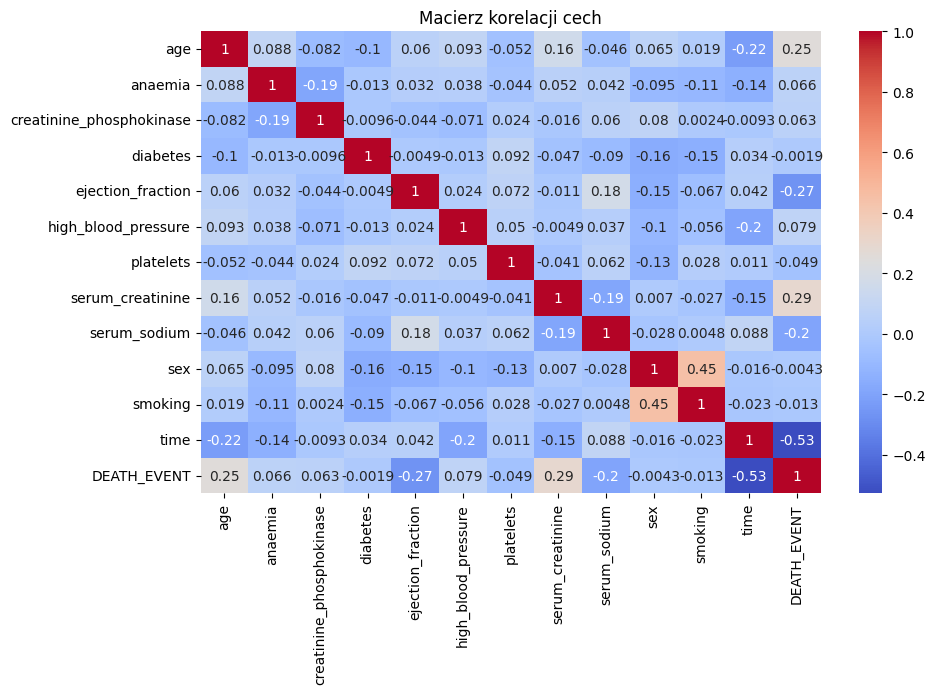

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Macierz korelacji cech")
plt.show()

Wykres przedstawia procent przeżycia pacjentów w różnych okresach obserwacji (follow-up period). Można zauważyć, że im dłuższy okres obserwacji, tym większe szanse na przeżycie, co sugeruje, że pacjenci, którzy przetrwali początkowe miesiące, mają lepsze rokowania. Jednak w 5. miesiącu następuje wyraźny spadek współczynnika przeżycia – z ponad 80% w 4. miesiącu do około 40% w 5. miesiącu, po czym w 6. miesiącu wskaźnik ponownie wzrasta powyżej 80%. Ten nagły spadek może wskazywać na krytyczny okres dla pacjentów i wymaga dalszej analizy.

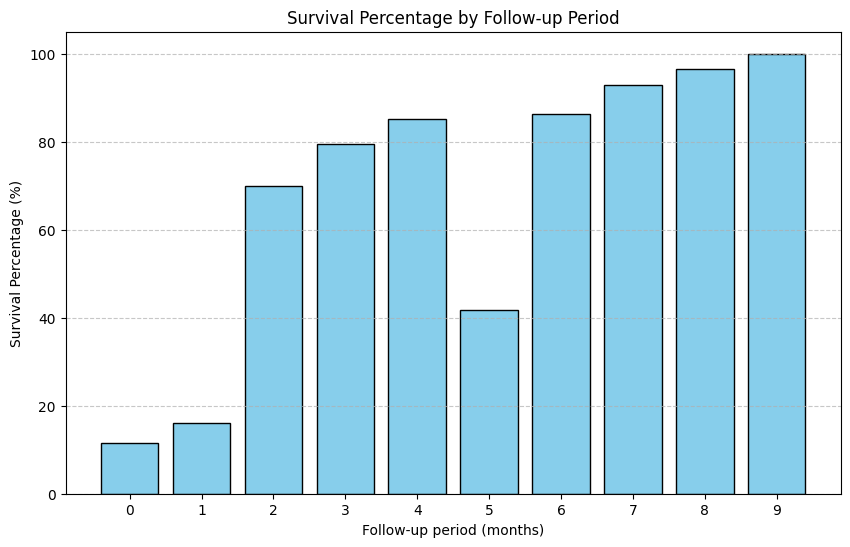

In [9]:
bins = np.arange(0, data['time'].max() + 30, 30)
data['time_bins'] = pd.cut(data['time'], bins, right=False)
at_risk = data['time_bins'].value_counts().sort_index()
survivors = data[data['DEATH_EVENT'] == 0]['time_bins'].value_counts().sort_index()
survival_percentage = (survivors / at_risk * 100).fillna(0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(survival_percentage)), survival_percentage.values, color='skyblue', edgecolor='black')
plt.xlabel('Follow-up period (months)')
plt.ylabel('Survival Percentage (%)')
plt.title('Survival Percentage by Follow-up Period')
plt.xticks(range(len(survival_percentage)), [f"{int(i.left/30)}" for i in survival_percentage.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3 Przygotowanie danych

### 3.1 Czyszczenie danych

Dane zostały odpowiednio przygotowane – nie występują w nich braki danych, a wszystkie zmienne są w formie numerycznej. Zmienne kategoryczne zostały już przekonwertowane na format binarny, co upraszcza proces analizy. Dzięki temu nie ma potrzeby dodatkowego czyszczenia danych przed przystąpieniem do kolejnych etapów analizy czy modelowania. Jedynie usuwam kolumnę pomocniczą utworzoną poprzednio do wykonania wykresu.

In [10]:
data = data.drop(columns=['time_bins'])
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

### 3.2 Wybór cech

3.2.1 Metoda chi kwadrat

Metoda chi-kwadrat została zastosowana do oceny zależności między poszczególnymi cechami a zmienną celu (DEATH_EVENT), poprzez porównanie oczekiwanych i zaobserwowanych częstości występowania wartości. Wyższe wartości statystyki chi-kwadrat sugerują silniejszy wpływ danej cechy na wynik, co umożliwia identyfikację najbardziej istotnych predyktorów.

In [11]:
X = data.drop(columns='DEATH_EVENT')
y = data['DEATH_EVENT']

X_scaled = MinMaxScaler().fit_transform(X)

chi2_scores, p_values = chi2(X_scaled, y)

chi2_importance = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)
chi2_importance

time                        14.050286
serum_creatinine             3.471610
age                          2.368846
ejection_fraction            1.894516
high_blood_pressure          1.221539
anaemia                      0.746593
serum_sodium                 0.267368
creatinine_phosphokinase     0.252029
platelets                    0.035021
smoking                      0.032347
sex                          0.001956
diabetes                     0.000657
dtype: float64

3.2.2 Metoda random forest

Metoda wyboru cech oparta na klasyfikatorze Random Forest ocenia znaczenie poszczególnych zmiennych poprzez analizę ich wpływu na poprawę dokładności modelu. Klasyfikator ten tworzy wiele drzew decyzyjnych, a cechy, które przyczyniają się do redukcji nieczystości w podziałach, uzyskują wyższe wartości ważności.

In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importance

time                        0.344041
serum_creatinine            0.141477
ejection_fraction           0.119073
age                         0.091657
creatinine_phosphokinase    0.087620
platelets                   0.081932
serum_sodium                0.074636
diabetes                    0.012655
sex                         0.012531
smoking                     0.012523
anaemia                     0.011405
high_blood_pressure         0.010449
dtype: float64

3.2.3 Metoda XGBoost

Metoda wyboru cech w XGBoost opiera się na ocenie, jak istotny jest wkład poszczególnych zmiennych w poprawę dokładności modelu. XGBoost, stosując technikę gradient boosting, buduje wiele drzew decyzyjnych, przy czym cechy, które przyczyniają się do największej redukcji błędu, otrzymują wyższe wartości ważności.

In [13]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X, y)
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_importance

c:\Users\lipton\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


time                        0.264820
serum_creatinine            0.126314
ejection_fraction           0.096487
age                         0.084107
anaemia                     0.083679
serum_sodium                0.081678
creatinine_phosphokinase    0.060092
diabetes                    0.058616
platelets                   0.053146
sex                         0.035607
high_blood_pressure         0.033788
smoking                     0.021665
dtype: float32

Porównanie wyboru najważniejszych cech przez użyte metody

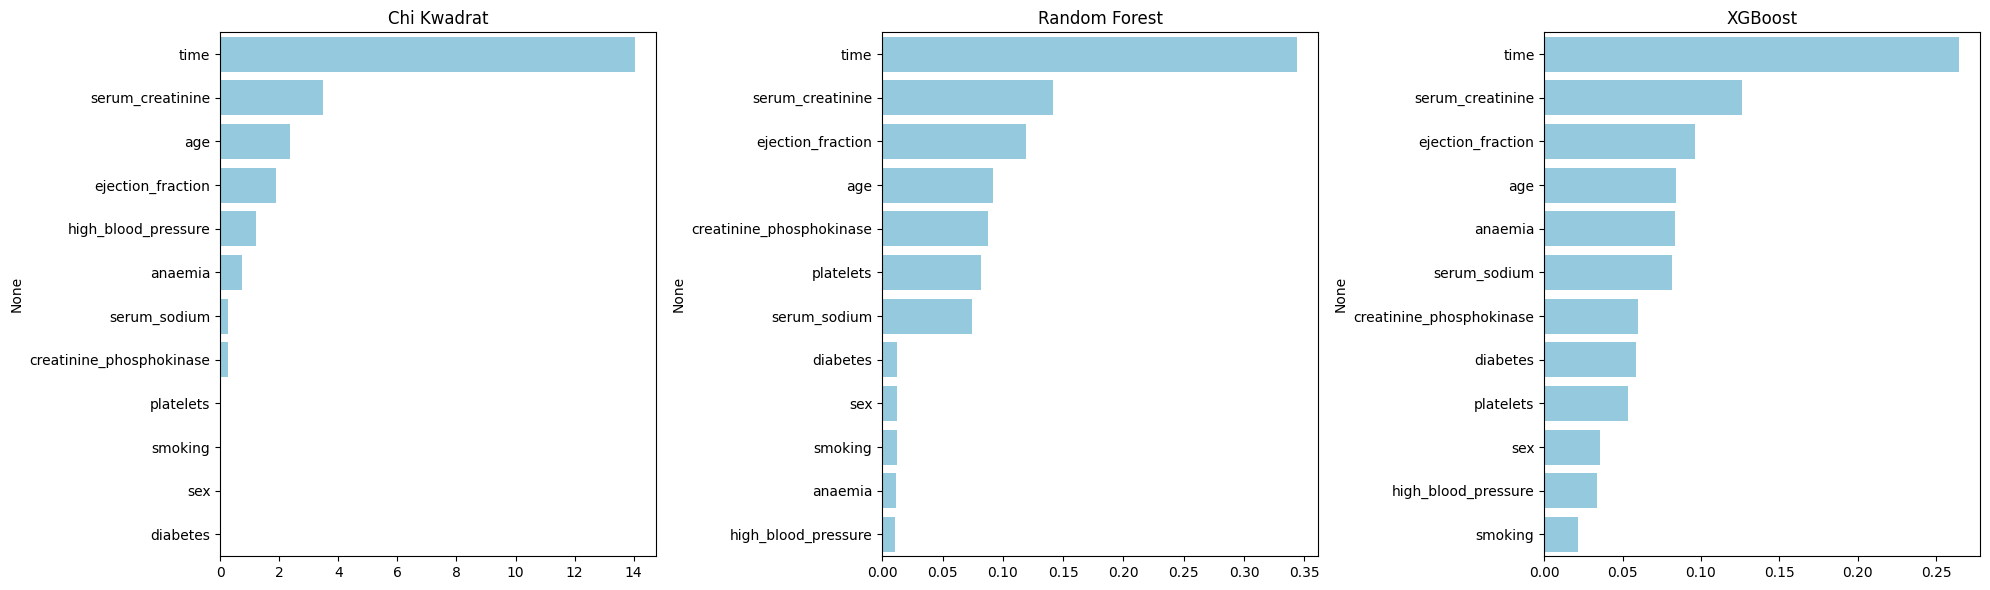

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.barplot(x=chi2_importance.values, y=chi2_importance.index, ax=axs[0], color='skyblue').set_title("Chi Kwadrat")
sns.barplot(x=rf_importance.values, y=rf_importance.index, ax=axs[1], color='skyblue').set_title("Random Forest")
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, ax=axs[2], color='skyblue').set_title("XGBoost")
plt.tight_layout()
plt.show()

Do dalszej analizy wybrano 8 najważniejszych cech według testu chi-kwadrat, przy czym pominięto zmienną „time”. Wynika to z faktu, że nasza analiza ma wspierać diagnozowanie i przewidywanie szans przeżycia oraz potrzeby dalszego leczenia, podczas gdy czas obserwacji stanowi parametr retrospektywny, użyteczny jedynie po zakończeniu leczenia.

In [15]:
top_columns = chi2_importance.head(8).index.tolist()

data_selected = data[top_columns]
data_selected = data_selected.drop(columns=['time'])

data_selected.head()

,serum_creatinine,age,ejection_fraction,high_blood_pressure,anaemia,serum_sodium,creatinine_phosphokinase
0,1.9,75.0,20,1,0,130,582
1,1.1,55.0,38,0,0,136,7861
2,1.3,65.0,20,0,0,129,146
3,1.9,50.0,20,0,1,137,111
4,2.7,65.0,20,0,1,116,160


### 3.3 Przekształcenia danych - analiza anomalii

Przeprowadzono analizę anomalii, jednak zdecydowano się nie usuwać żadnych wartości odstających, gdyż są to dane medyczne. W badaniach medycznych skrajne odchylenia od normy mogą być istotnym elementem diagnozy. Na wykresach widoczne są duże klastry wartości odstających, które wskazują na brak pomyłki. 

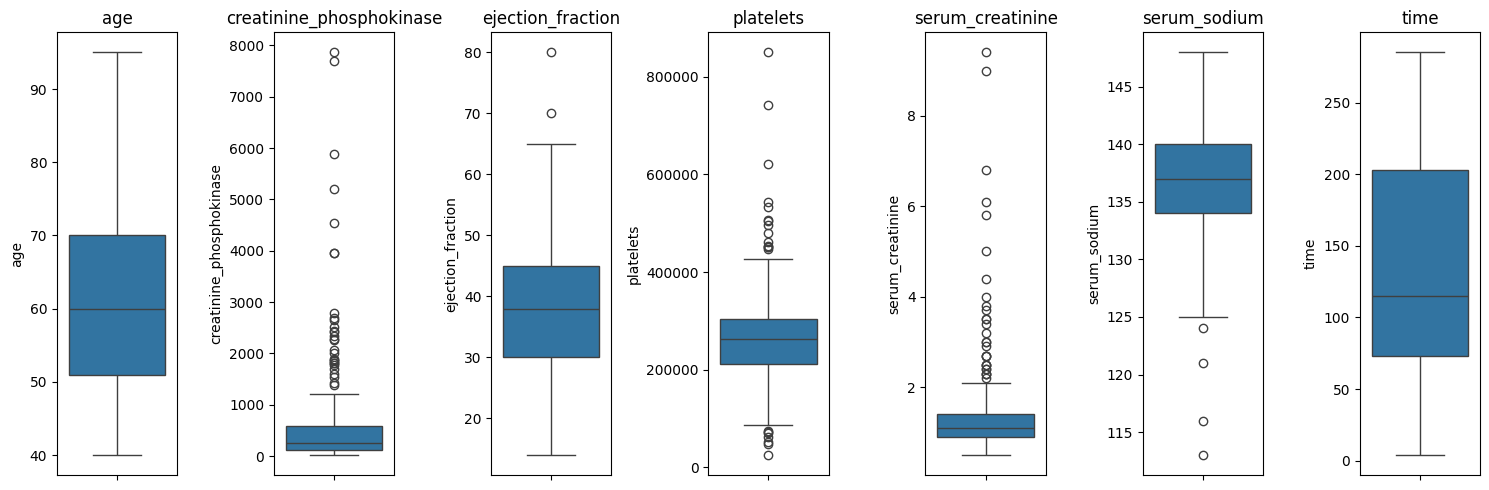

In [16]:
selected_columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(15, 5))
axs = axs.flatten()

for index, column in enumerate(selected_columns):
    if index < len(axs):
        sns.boxplot(y=data[column], ax=axs[index])
        axs[index].set_title(column)

plt.tight_layout()
plt.show()

## 4 Tworzenie modelu i ocena

### 4.1 Podział zbioru danych

Zbiór danych został podzielony na dwie części – 80% danych treningowych oraz 20% testowych – co umożliwia efektywne uczenie modelu przy jednoczesnej wiarygodnej ocenie jego skuteczności na nieznanych danych. Taki podział zapewnia wystarczającą ilość przykładów do nauki, jednocześnie chroniąc przed przeuczeniem, a ustawienie parametru random_state=0 gwarantuje powtarzalność wyników, co jest istotne dla spójności analiz.

In [17]:
X = data_selected
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 4.2 Wykorzystane metody

4.2.1 Random Forest

Random Forest to zaawansowana metoda zespołowa, która buduje wiele drzew decyzyjnych na losowych podzbiorach danych i cech, co umożliwia uzyskanie zróżnicowanych modeli. Wyniki poszczególnych drzew są następnie łączone poprzez głosowanie większościowe, co znacząco zwiększa stabilność i dokładność predykcji. Taki mechanizm agregacji redukuje ryzyko przeuczenia, typowe dla pojedynczych drzew decyzyjnych, oraz poprawia zdolność modelu do generalizacji na nowych danych. 

Konfiguracja modelu z 100 drzewami oraz ustalonym stanem generatora liczb losowych (random_state=0) gwarantuje powtarzalność wyników.

In [18]:
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        37
           1       0.73      0.48      0.58        23

    accuracy                           0.73        60
   macro avg       0.73      0.69      0.69        60
weighted avg       0.73      0.73      0.72        60



4.2.2 Naiwny klasyfikator bayesowski

Naiwny klasyfikator bayesowski opiera się na założeniu o niezależności cech oraz przyjmuje, że dane mają rozkład normalny. Model ten uczy się na zbiorze treningowym, wykorzystując prawdopodobieństwa poszczególnych cech do określenia przynależności obserwacji do określonych klas. Po przeszkoleniu, model dokonuje predykcji na zbiorze testowym. Dzięki swojej prostocie i szybkości działania jest on często wykorzystywany w zadaniach klasyfikacyjnych, gdzie priorytetem jest szybkie przetwarzanie danych.

In [19]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76        37
           1       0.60      0.26      0.36        23

    accuracy                           0.65        60
   macro avg       0.63      0.58      0.56        60
weighted avg       0.64      0.65      0.61        60



4.2.3 Gradient Boost

Gradient Boosting to metoda zespołowa, która buduje model predykcyjny poprzez sekwencyjne dodawanie słabych klasyfikatorów, najczęściej drzew decyzyjnych. Każde kolejne drzewo stara się korygować błędy popełnione przez poprzednie modele, koncentrując się na przypadkach trudniejszych do sklasyfikowania. Dzięki temu algorytm potrafi wychwycić skomplikowane zależności między zmiennymi, co przekłada się na wysoką dokładność predykcji. 

Ustawienie parametru n_estimators na 100 oznacza, że model został zbudowany w 100 iteracjach, co pozwala stopniowo udoskonalać jego wyniki bez nadmiernego przeuczenia.

In [20]:
gb_model = GradientBoostingClassifier(random_state=0, n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80        37
           1       0.71      0.52      0.60        23

    accuracy                           0.73        60
   macro avg       0.73      0.69      0.70        60
weighted avg       0.73      0.73      0.72        60



### 4.3 Wyniki i porównanie algorytmów

Z przedstawionych wyników wynika, że zarówno Random Forest, jak i Gradient Boosting osiągają taką samą dokładność (73,3%), przewyższając tym samym Naive Bayes (65%). Różnice między tymi dwoma algorytmami zespołowymi są niewielkie: Gradient Boosting ma nieznacznie wyższy wskaźnik F1 (0,723) w porównaniu do Random Forest (0,718). Naive Bayes notuje niższe wyniki we wszystkich miarach (dokładność, precyzja, czułość, F1), co potwierdza większą liczbę błędnych klasyfikacji w macierzy pomyłek. W przypadku Random Forest i Gradient Boosting widać natomiast wyraźnie mniejszą liczbę błędnych predykcji, zwłaszcza w klasie pozytywnej.

C:\Users\lipton\AppData\Local\Temp\ipykernel_15036\1459692727.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, pd.DataFrame({


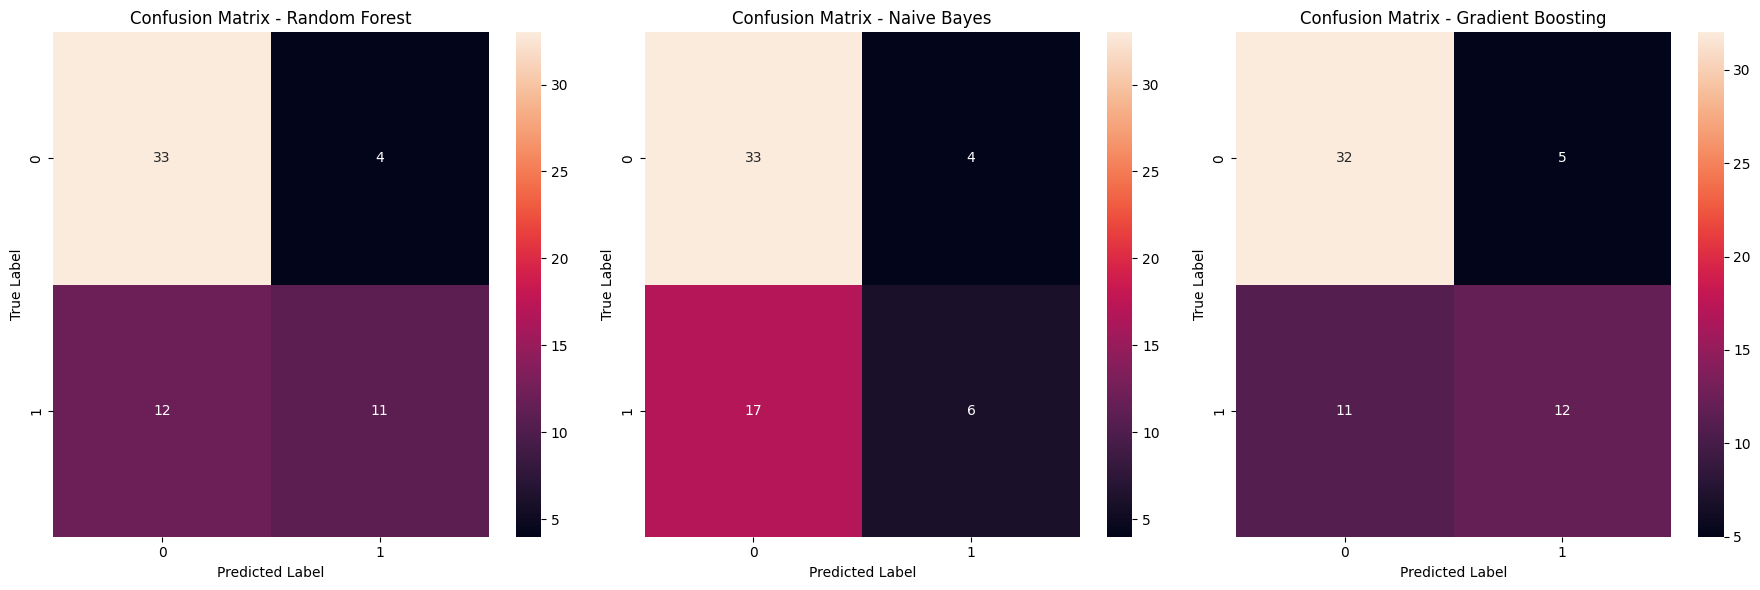

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.733333,0.733333,0.733333,0.718271
Gradient Boosting,0.733333,0.729503,0.733333,0.723333
Naive Bayes,0.650000,0.637000,0.650000,0.607210


In [21]:
models = {
    "Random Forest": y_pred_rf,
    "Naive Bayes": y_pred_nb,
    "Gradient Boosting": y_pred_gb
}

results_table = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

for model_name, y_pred in models.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    results_table = pd.concat([results_table, pd.DataFrame({
        "Model": [model_name],
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1_score]
    })], ignore_index=True)

predictions = [y_pred_rf, y_pred_nb, y_pred_gb]
model_names = ['Random Forest', 'Naive Bayes', 'Gradient Boosting']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (y_pred, model_name) in enumerate(zip(predictions, model_names)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(f'Confusion Matrix - {model_name}')
    axs[i].set_xlabel('Predicted Label')
    axs[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

results_table.set_index("Model", inplace=True)
results_table = results_table.sort_values(by="Accuracy", ascending=False)
results_table


### 4.4 Przykładowy wynik

In [22]:
X = data_selected
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

num_examples = 5
example_indices = X_test.index[:num_examples]
X_examples = X_test.loc[example_indices]
y_true = y_test.loc[example_indices]
y_pred_examples = rf_model.predict(X_examples)

results_examples = pd.DataFrame({
    "Input Features": X_examples.values.tolist(),
    "True Label": y_true.values,
    "Predicted Label": y_pred_examples
})

results_examples.index = example_indices
results_examples

,Input Features,True Label,Predicted Label
274,"[1.0, 60.0, 30.0, 0.0, 1.0, 137.0, 257.0]",0,0
149,"[0.9, 60.0, 35.0, 1.0, 0.0, 136.0, 2261.0]",0,0
120,"[1.5, 60.0, 60.0, 1.0, 1.0, 135.0, 737.0]",0,0
226,"[1.3, 58.0, 25.0, 0.0, 1.0, 132.0, 57.0]",0,1
125,"[1.3, 43.0, 50.0, 0.0, 1.0, 135.0, 358.0]",0,0


### 4.5 Poprawianie wyniku

Zmniejszenie liczby cech z siedmiu do trzech (tj. serum_creatinine, age, ejection_fraction) pozwoliło poprawić skuteczność klasyfikatora Random Forest. Ograniczenie zbioru cech do najbardziej istotnych predyktorów według testu chi-kwadrat podniosło dokładność modelu do **78%**, co jest lepszym wynikiem niż wcześniej uzyskane 73%. 

Takie podejście może również pomóc uniknąć przeuczenia, ponieważ model koncentruje się na najbardziej znaczących zmiennych, redukując „szum” informacyjny. Ponadto mniejsza liczba cech ułatwia interpretację wyników i może być bardziej praktyczna w warunkach klinicznych, gdzie liczy się zarówno trafność, jak i zawężenie badań do minimum.

In [23]:
top_columns = chi2_importance.head(4).index.tolist()

data_selected = data[top_columns]
data_selected = data_selected.drop(columns=['time'])

data_selected.head()

,serum_creatinine,age,ejection_fraction
0,1.9,75.0,20
1,1.1,55.0,38
2,1.3,65.0,20
3,1.9,50.0,20
4,2.7,65.0,20


In [24]:
X = data_selected
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        37
           1       0.81      0.57      0.67        23

    accuracy                           0.78        60
   macro avg       0.79      0.74      0.75        60
weighted avg       0.79      0.78      0.77        60

Accuracy: 0.7833333333333333


## 5 Wnioski

Przeprowadzona analiza dotyczyła problemu klasyfikacyjnego, którego głównym celem jest stworzenie modelu pozwalającego przewidywać przeżywalność pacjentów z niewydolnością serca. 

W badaniu uwzględniono kilka algorytmów uczenia maszynowego – w szczególności Random Forest, Gradient Boosting oraz Naive Bayes – które porównano pod kątem dokładności, precyzji, czułości i miary F1. Wyniki pokazały, że metody zespołowe (Random Forest i Gradient Boosting) osiągają wyższą skuteczność (około 73,3%) niż Naive Bayes (65%), przy czym różnice między dwoma pierwszymi algorytmami są niewielkie.

Kluczowym odkryciem jest to, że zredukowanie liczby cech do zaledwie trzech (serum creatinine, ejection fraction, age) nie tylko upraszcza model, ale również zwiększa jego dokładność – nawet do 78% w przypadku Random Forest. Potwierdza to wnioski z literatury, gdzie podkreśla się, że właśnie stężenie kreatyniny w surowicy (serum creatinine) oraz frakcja wyrzutowa (ejection fraction) mają kluczowe znaczenie przy ocenie ryzyka zgonu pacjentów z niewydolnością serca.

Te wyniki pokazują, jak istotne jest odpowiednie dobranie metody selekcji cech oraz wybór właściwego modelu predykcyjnego. Dzięki temu można nie tylko poprawić skuteczność klasyfikacji, ale też uniknąć przeuczenia i zwiększyć przejrzystość oraz przydatność kliniczną uzyskanego modelu. W praktyce lekarskiej oznacza to, że lekarze mogą skupić się głównie na badaniu poziomu kreatyniny w surowicy i ocenie frakcji wyrzutowej, aby szybko i efektywnie oszacować ryzyko zgonu pacjenta z niewydolnością serca. Takie podejście może mieć realny wpływ na codzienną praktykę medyczną, dostarczając specjalistom prostego, a zarazem wiarygodnego narzędzia wspierającego diagnostykę i decyzje terapeutyczne.